In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import os, sys
cwd = os.getcwd()

api_path_сifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
models_cifar_scratch_path = os.path.join(cwd, '..', 'models_cifar10')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_сifar)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

# DCGAN from scratch

In [75]:
import numpy as np
import time
import random
import glob
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from functools import partial

from dataloader import get_loader
from trainer import Trainer
from discriminator import Discriminator
from generator import Generator
from cifar10_utils import plot_images, save_predictions_on_test

from params_cifar10 import args
from general_utils import to_var, DotDict, to_np

from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from metrics import inception_score
from dataloader import GenDataset, LatentFixDataset

In [5]:
args.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = args.device

G = Generator(args).to(args.device)
D = Discriminator(args).to(args.device)

In [5]:
models_regexp = os.path.join(models_cifar_scratch_path, "*.pth")
models_name = [f for f in glob.glob(models_regexp)][0]

In [10]:
ckpt = torch.load(models_name, map_location = device)

In [11]:
G.load_state_dict(ckpt['G'])
D.load_state_dict(ckpt['D'])

<All keys matched successfully>

In [12]:
G.eval()
D.eval()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)

In [13]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)

In [14]:
fixed_z_var = to_var(fixed_z, device = args.device)
samples = G(fixed_z_var)
samples_normalized = ((samples + 1) / 2).clamp(0, 1)

In [15]:
images_torch = samples_normalized.data

In [16]:
images_torch.shape

torch.Size([64, 3, 32, 32])

In [17]:
def plot_images(images_torch):
    batch_size_sample = images_torch.shape[0]
    numpy_images = images_torch.detach().cpu().numpy().transpose(0, 2, 3, 1)
    numpy_images = (numpy_images - numpy_images.min())/(numpy_images.max() - numpy_images.min())
    nrow = int(batch_size_sample**0.5)
    fig = plt.figure(figsize=(20, 20))
    axes = fig.subplots(nrow, nrow)
    for k in range(batch_size_sample):
        i = k // nrow
        j = k % nrow
        #axes[i][j].imshow(np.clip(numpy_images[k], 0, 1))
        axes[i][j].imshow(numpy_images[k])
        axes[i][j].axis('off')
    plt.show()

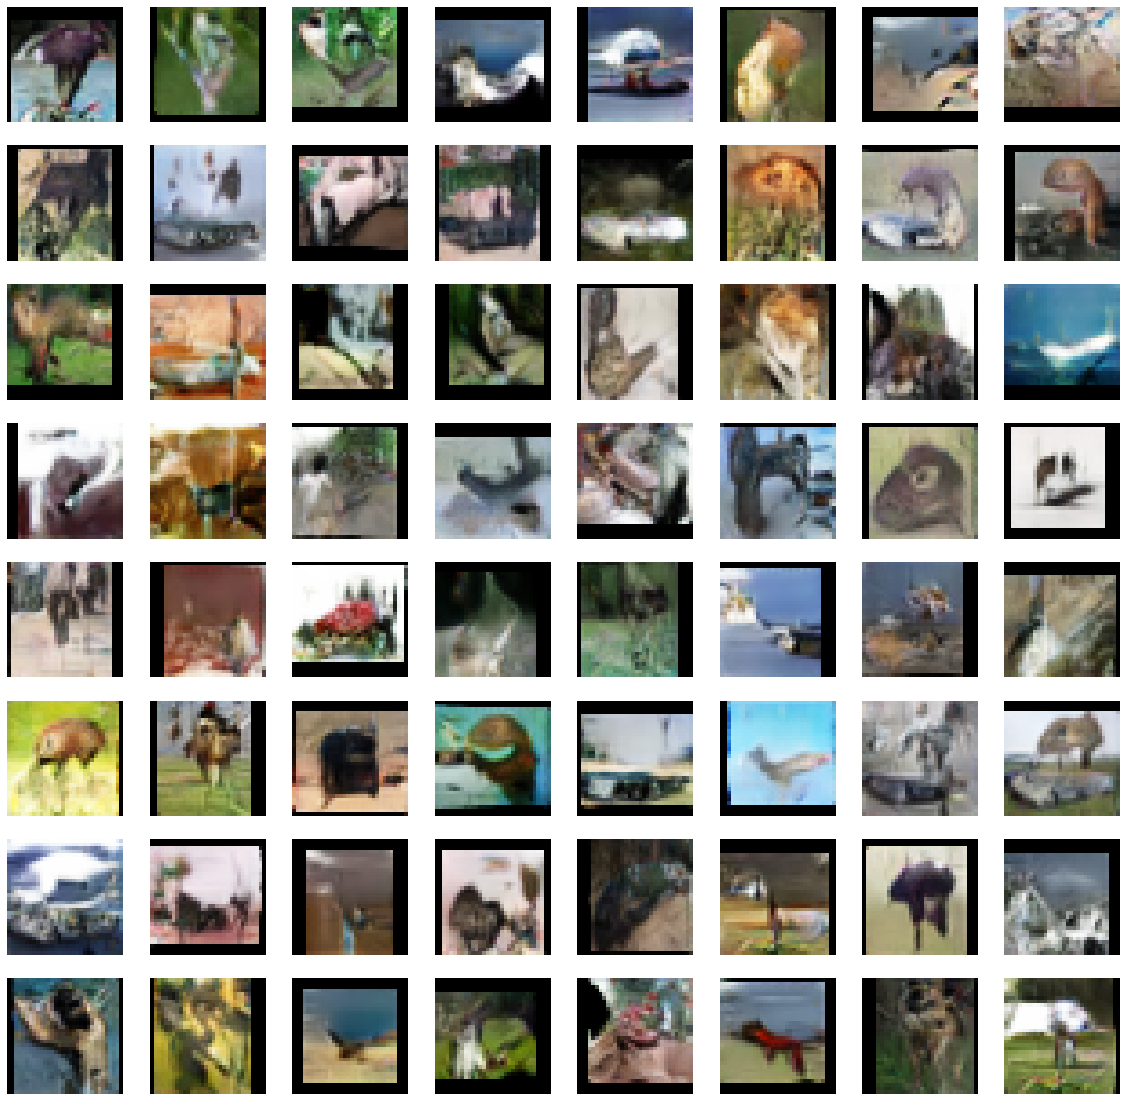

In [18]:
plot_images(images_torch)

In [39]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)
fixed_z_var = to_var(fixed_z, device = args.device)
fake_imgs = G(fixed_z_var).detach()

D_outputs = D(fake_imgs)

In [40]:
print(D_outputs.cpu().data)

tensor([ 0.4882, -0.0089, -0.4454, -0.4099, -1.0083, -0.2816, -0.6268, -0.6639,
        -0.8809, -0.3667, -1.0376, -1.2791, -1.0204, -0.2664, -0.5179, -0.5680,
        -0.7019, -0.8253, -0.5849, -0.5829, -0.3266, -0.2924, -0.7480,  0.1548,
        -1.1504, -0.7655, -0.8689, -0.6749, -0.4382, -0.4512, -0.4666, -1.0219,
        -0.8999,  0.3879,  0.3935, -0.9945, -0.4973, -0.2164, -0.7172,  0.1660,
        -0.1303, -0.1041, -0.8570, -0.6268, -0.8746, -0.4242, -1.0792, -0.8190,
        -1.1584, -0.3265, -0.8152, -0.3668, -0.7580, -0.0855,  0.0222, -0.5584,
        -0.5298, -0.7238, -0.3428, -0.5520, -0.2844, -0.4112, -0.3965, -0.1336])


In [28]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
num_samples = 50000
dataset = GenDataset(G, num_samples)

In [29]:
start = time.time()
score_mean, score_std = inception_score(dataset, device, args.batch_size, True)
end = time.time() - start
print(f"time for inception calculation = {end}")

Start to make predictions
Start to compute KL divergence
time for inception calculation = 380.4678430557251


In [30]:
print(f"inception score = {score_mean}")

inception score = 4.324181273940167


In [31]:
score_std

0.05538793339919849

# ULA

In [20]:
z_dim = G.z_dim
device = args.device
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True
target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [21]:
def grad_energy(point, target, x=None):
    point = point.detach().requires_grad_()
    if x is not None:
        energy = -target(z=point, x=x)
    else:
        energy = -target(point)
    grad = torch.autograd.grad(energy.sum(), point)[0]
    return energy, grad 

def langevin_dynamics(z, target, proposal, n_steps, grad_step, eps_scale):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        eps = eps_scale*proposal.sample([batch_size])

        E, grad = grad_energy(z, target, x=None)
        z = z - grad_step * grad + eps        
        z = z.data
        z.requires_grad_(True)
    z_sp.append(z)
    return z_sp

In [22]:
def langevin_sampling(target, proposal, n_steps, grad_step, eps_scale, n, batch_size):
    z_last = []
    zs = []
    z = proposal.sample([batch_size])
    
    for i in tqdm(range(0, n, batch_size)):
        z = proposal.sample([batch_size])
        z.requires_grad_(True)
        z_sp = langevin_dynamics(z, target, proposal, n_steps, grad_step, eps_scale)
        last = z_sp[-1].data.cpu().numpy()
        z_last.append(last)
        zs.append(np.stack([o.data.cpu().numpy() for o in z_sp], axis=0))

    z_last_np = np.asarray(z_last).reshape(-1, z.shape[-1])
    zs = np.stack(zs, axis=0)
    return z_last_np, zs

In [23]:
batch_size = 1000
n = 50000
n_steps = 100
grad_step = 0.01
eps_scale = (2*grad_step)**0.5
z_last_np, zs = langevin_sampling(target_gan, proposal, n_steps, grad_step, eps_scale, n, batch_size)

100%|██████████| 50/50 [31:17<00:00, 37.55s/it]


In [24]:
nsamples = len(z_last_np)
latent_arr = torch.FloatTensor(z_last_np)
latent_dataset = LatentFixDataset(latent_arr, G, device, nsamples)

In [25]:
score_mean_langevin, score_std_langevin = inception_score(latent_dataset, device, args.batch_size, True)

Start to make predictions
Start to compute KL divergence


In [26]:
print(f"inception score for Langevin = {score_mean_langevin}")

inception score for Langevin = 4.455136821353747


In [27]:
score_std_langevin

0.060840390273751495

In [32]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)
fixed_z_var = to_var(fixed_z, device = args.device)
n_steps = 100
grad_step = 0.01
eps_scale = (2*grad_step)**0.5

z_sp = langevin_dynamics(fixed_z_var, target_gan, proposal, n_steps, grad_step, eps_scale)

In [33]:
last = z_sp[-1].data.cpu().numpy()

In [34]:
last_tensor = torch.FloatTensor(last)
last_var = to_var(last_tensor, device = args.device)
samples_last = G(last_var)
samples_normalized_last = ((samples_last + 1) / 2).clamp(0, 1)
images_torch_langevin = samples_normalized_last.data

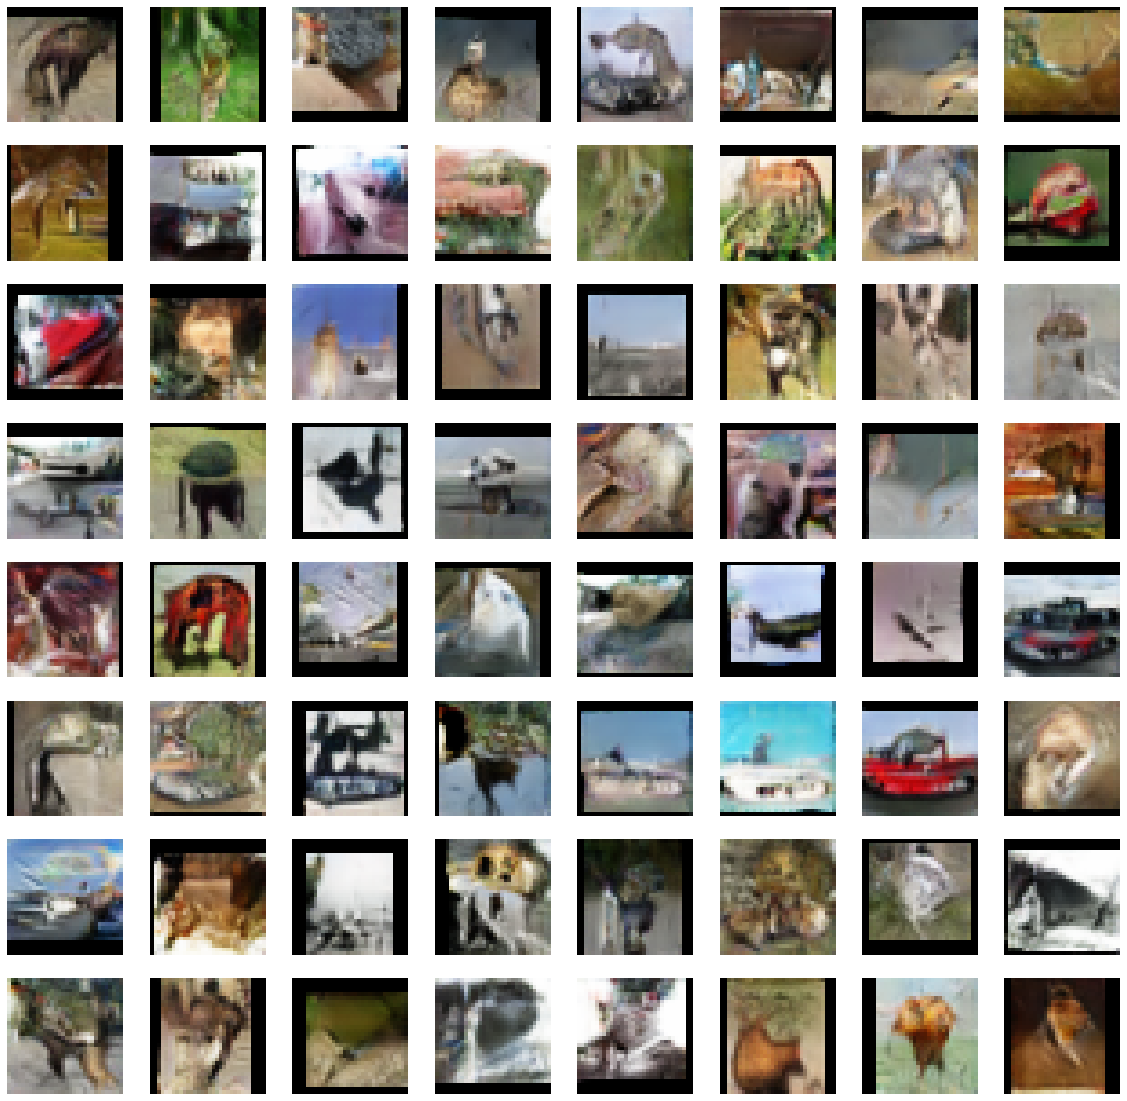

In [35]:
plot_images(images_torch_langevin)

In [36]:
D_outputs_langevin = D(images_torch_langevin)

In [41]:
print(D_outputs_langevin.cpu().data)

tensor([-0.1690,  0.6560, -0.1439, -0.1246, -0.6413, -0.4309,  0.2597, -0.2173,
         0.3261,  0.0961, -0.1336, -0.3123,  0.1727,  0.3406, -0.5417,  0.2734,
         0.6052, -0.7443,  0.3562,  0.5413, -0.0608, -0.3527,  0.1708, -0.2577,
        -0.6245, -0.1478,  0.9162, -0.3999, -0.0508, -0.1695, -0.0988, -0.1366,
        -0.5102,  0.6957,  0.0136, -0.1176, -0.3694, -0.3381,  0.3602, -0.3670,
        -0.3144, -0.3400, -0.0491, -0.4607,  0.0170,  0.3036, -0.0179, -0.4077,
         0.1317,  0.0519,  0.9208, -0.2873, -0.0903, -0.1310, -0.0449, -0.5860,
        -0.7238, -0.0621,  0.7971, -0.6163, -0.4775,  0.9715,  0.3001,  0.7699])


In [43]:
D_outputs.cpu().data

tensor([ 0.4882, -0.0089, -0.4454, -0.4099, -1.0083, -0.2816, -0.6268, -0.6639,
        -0.8809, -0.3667, -1.0376, -1.2791, -1.0204, -0.2664, -0.5179, -0.5680,
        -0.7019, -0.8253, -0.5849, -0.5829, -0.3266, -0.2924, -0.7480,  0.1548,
        -1.1504, -0.7655, -0.8689, -0.6749, -0.4382, -0.4512, -0.4666, -1.0219,
        -0.8999,  0.3879,  0.3935, -0.9945, -0.4973, -0.2164, -0.7172,  0.1660,
        -0.1303, -0.1041, -0.8570, -0.6268, -0.8746, -0.4242, -1.0792, -0.8190,
        -1.1584, -0.3265, -0.8152, -0.3668, -0.7580, -0.0855,  0.0222, -0.5584,
        -0.5298, -0.7238, -0.3428, -0.5520, -0.2844, -0.4112, -0.3965, -0.1336])

In [42]:
(D_outputs.cpu().data < D_outputs_langevin.cpu().data).sum()

tensor(48)

# Pretrained DCGAN

In [4]:
from fid_score import calculate_fid_given_paths
from kid_score import calculate_kid_given_paths
from params_cifar10 import args

In [5]:
num_gpu = 1 if torch.cuda.is_available() else 0

# load the models
from dcgan import Discriminator_cifar10, Generator_cifar10

D = Discriminator_cifar10(ngpu=1).eval()
G = Generator_cifar10(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load(os.path.join(models_cifar_scratch_path, 'netD_epoch_199.pth')))
G.load_state_dict(torch.load(os.path.join(models_cifar_scratch_path, 'netG_epoch_199.pth')))

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    D = D.to(device)
    G = G.to(device)
    
G.z_dim = 100
G.device = device

In [6]:
batch_size = 25
latent_size = 100
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.to(device)
fake_images = G(fixed_noise)

In [7]:
samples_normalized = ((fake_images + 1) / 2).clamp(0, 1)
images_torch = samples_normalized.data

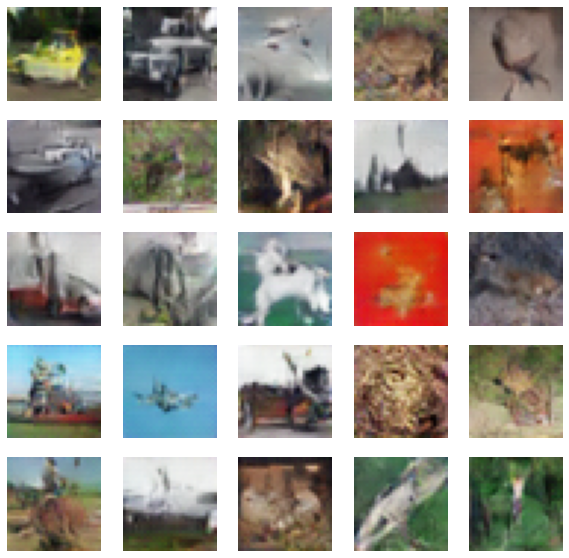

In [8]:
plot_images(images_torch)

In [15]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
num_samples = 50000
z_dim = 100
dataset = GenDataset(G, num_samples, 
                     pretrained = True, device = device, z_dim = z_dim)

In [47]:
start = time.time()
score_mean, score_std = inception_score(dataset, device, args.batch_size, True)
end = time.time() - start
print(f"time for inception calculation = {end}")

Start to make predictions
Start to compute KL divergence
time for inception calculation = 390.48364210128784


In [48]:
print(f"mean inceptions score = {score_mean}, std inception score = {score_std}")

mean inceptions score = 5.467128630015777, std inception score = 0.0654524619783404


In [10]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

path_to_save_cifar10 = os.path.join(cwd, '..', 'samples', 'cifar10', 'downloaded_dataset')

test_dataset = dset.CIFAR10(root=path_to_save_cifar10, 
                               train=False,
                               download=True,
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

real_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                              shuffle=True, num_workers=4)

Files already downloaded and verified


In [11]:
real_batch = next(iter(real_dataloader))[0]

In [12]:
real_batch.min()

tensor(-1.)

In [13]:
real_batch.max()

tensor(1.)

In [16]:
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
name_fake_test = os.path.join(path_to_save_cifar10_np, "pretrained_fake_test.npy")
name_real_test = os.path.join(path_to_save_cifar10_np, "pretrained_real_test.npy")
save_predictions_on_test(G,
                         real_dataloader,
                         name_fake_test,
                         name_real_test,
                         z_dim,
                         device, 
                         random_seed)

In [18]:
paths_to_test = [name_real_test, name_fake_test]

batch_size_resnet = 50
dim = 2048 
model_type = 'inception'
cuda = True

results_fid = calculate_fid_given_paths(paths_to_test, 
                                         batch_size_resnet, 
                                         cuda, 
                                         dim, 
                                         model_type=model_type)

  0%|          | 1/200 [00:00<00:21,  9.12it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/pretrained_fake_test.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it, mean=40.5]


In [19]:
results_fid = results_fid[0]

mean_fid = results_fid[1]
std_fid = results_fid[2]

print(f"FID score for CIFAR10: mean {mean_fid}, score {std_fid}")

FID score for CIFAR10: mean 40.50564422116368, score 0.4438681962025296


In [23]:
a = torch.ones((4, 4))
a = a.unsqueeze(-1).unsqueeze(-1)
print(a.shape)

torch.Size([4, 4, 1, 1])


In [26]:
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = False

def z_transform(z):
    return z.unsqueeze(-1).unsqueeze(-1)

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob,
                     z_transform = z_transform)

In [ ]:
batch_size = 1000
n = 50000
n_steps = 100
grad_step = 0.01
eps_scale = (2*grad_step)**0.5
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n, n_steps, grad_step, eps_scale)

 92%|█████████▏| 46/50 [20:43<01:48, 27.12s/it]

In [100]:
z_last_np_no_nans = []
for i in range(z_last_np.shape[0]):
    if np.isnan(z_last_np[i]).sum()==0:
        z_last_np_no_nans.append(z_last_np[i])
z_last_np_no_nans = np.array(z_last_np_no_nans)

In [101]:
z_last_np_no_nans.shape

(44453, 100)

In [103]:
nsamples = len(z_last_np_no_nans)
latent_arr = torch.FloatTensor(z_last_np_no_nans)
latent_arr_transform = z_transform(latent_arr).unsqueeze(dim=1)
latent_dataset = LatentFixDataset(latent_arr_transform, G, device, nsamples)

In [104]:
latent_arr_transform.shape

torch.Size([44453, 1, 100, 1, 1])

In [105]:
score_mean_langevin, score_std_langevin = inception_score(latent_dataset, device, args.batch_size, True)

Start to make predictions
Start to compute KL divergence


In [106]:
print(f"ULA mean inceptions score = {score_mean_langevin}, std inception score = {score_std_langevin}")

ULA mean inceptions score = 5.529901797061622, std inception score = 0.05813955177624292


In [108]:
def save_predictions_on_test_fix_latent(G,
                             real_dataloader,
                             name_fake_test,
                             name_real_test,
                             latent_arr,
                             device,
                             random_seed):
    fake_list = []
    real_list = []
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    max_num_imgs = latent_arr.shape[0]
    start_ind = 0

    for  i, data_real in enumerate(real_dataloader, 0):
        batch_real = data_real[0]
        batch_size = batch_real.shape[0]
        
        if (start_ind + batch_size <= max_num_imgs):
            fixed_noise = latent_arr[start_ind:start_ind + batch_size].to(device)
            fake_images = G(fixed_noise)
            start_ind += batch_size
            
            fake_norm_np = ((1. + fake_images)/2).detach().cpu().numpy()
            real_norm_np = ((1. + batch_real)/2).detach().cpu().numpy()
            fake_list.append(fake_norm_np)
            real_list.append(real_norm_np)
            
        else:
            fixed_noise = latent_arr[start_ind:].to(device)
            fake_images = G(fixed_noise)
            add_num_imgs = max_num_imgs - start_ind
            batch_real = batch_real[:add_num_imgs]
            
            fake_norm_np = ((1. + fake_images)/2).detach().cpu().numpy()
            real_norm_np = ((1. + batch_real)/2).detach().cpu().numpy()
            fake_list.append(fake_norm_np)
            real_list.append(real_norm_np)
            break 

    fake_np = np.concatenate(fake_list)
    real_np = np.concatenate(real_list)
    
    print(fake_np.shape)
    print(real_np.shape)

    np.save(name_fake_test, fake_np)
    np.save(name_real_test, real_np)

In [109]:
latent_arr_transform_2 = z_transform(latent_arr)

In [111]:
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
name_fake_test_ula = os.path.join(path_to_save_cifar10_np, "ula_pretrained_fake_test.npy")
name_real_test_ula = os.path.join(path_to_save_cifar10_np, "ula_pretrained_real_test.npy")
save_predictions_on_test_fix_latent(G,
                         real_dataloader,
                         name_fake_test_ula,
                         name_real_test_ula,
                         latent_arr_transform_2,
                         device, 
                         random_seed)

(10000, 3, 32, 32)
(10000, 3, 32, 32)


In [112]:
paths_to_test_ula = [name_real_test_ula, name_fake_test_ula]

batch_size_resnet = 50
dim = 2048 
model_type = 'inception'
cuda = True

results_fid = calculate_fid_given_paths(paths_to_test_ula, 
                                         batch_size_resnet, 
                                         cuda, 
                                         dim, 
                                         model_type=model_type)

  0%|          | 1/200 [00:00<00:21,  9.39it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it, mean=36.9]


In [113]:
results_fid = results_fid[0]

mean_fid = results_fid[1]
std_fid = results_fid[2]

print(f"FID score for CIFAR10 with ULA: mean {mean_fid}, score {std_fid}")

FID score for CIFAR10 with ULA: mean 36.92684352794439, score 0.5238915763163959
